In [ ]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import spearmanr

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import haversine_distances

import mantel

import zipfile
import os

In [ ]:
def dp(dist_mat):
    N, M = dist_mat.shape

    cost_mat = np.zeros((N + 1, M + 1))
    cost_mat[1:, 0] = np.inf
    cost_mat[0, 1:] = np.inf

    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [cost_mat[i, j], cost_mat[i, j + 1], cost_mat[i + 1, j]]
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    i, j = N - 1, M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        i, j = (i - 1, j - 1) if tb_type == 0 else ((i - 1, j) if tb_type == 1 else (i, j - 1))
        path.append((i, j))

    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [ ]:
def two_comparison(a_audio, b_audio):
    f_sx, x = wavfile.read(a_audio)
    f_sy, y = wavfile.read(b_audio)

    n_fft = int(0.025 * f_sx)      # 25 ms
    hop_length = int(0.01 * f_sx)  # 10 ms

    log_mel_spec_x = np.log(librosa.feature.melspectrogram(x / 1.0, sr=f_sx, n_mels=40, n_fft=n_fft, hop_length=hop_length))
    log_mel_spec_y = np.log(librosa.feature.melspectrogram(y / 1.0, sr=f_sy, n_mels=40, n_fft=n_fft, hop_length=hop_length))

    path, cost_mat = dp(dist.cdist(log_mel_spec_x.T, log_mel_spec_y.T, "cosine"))

    M, N = log_mel_spec_y.shape[0], log_mel_spec_x.shape[0]

    return path, cost_mat, M, N

In [ ]:
def comparison(list_of_audio):
    q = len(list_of_audio)
    seq_dict = {}
    not_df = {}

    for audio in list_of_audio:
        audio_name = str(audio)
        f_s, z = wavfile.read(audio)
        n_fft = int(0.025 * f_s)      # 25 ms
        hop_length = int(0.01 * f_s)  # 10 ms
        log_mel_spec_z = np.log(librosa.feature.melspectrogram(z / 1.0, sr=f_s, n_mels=40, n_fft=n_fft, hop_length=hop_length))
        seq_dict[audio_name] = log_mel_spec_z.T

    for name_main, seq_main in seq_dict.items():
        row_dict = {}
        M = seq_main.shape[0]

        for name_snd, seq_snd in seq_dict.items():
            dist_mat = dist.cdist(seq_main, seq_snd, "cosine")
            path, cost_mat = dp(dist_mat)
            N = seq_snd.shape[0]
            normalized = cost_mat[-1, -1] / (M + N)
            row_dict[name_snd] = "%.8f" % normalized

        not_df[name_main] = row_dict

    return pd.DataFrame(not_df)

In [ ]:
def get_sequences(list_of_audio):
    return {
        str(audio): np.log(librosa.feature.melspectrogram(q / 1.0, sr=f_s, n_mels=40, n_fft=int(0.025 * f_s), hop_length=int(0.01 * f_s))).T
        for audio in list_of_audio
    }

In [ ]:
import os
import zipfile

def compare_wav_files(audios):
    with zipfile.ZipFile(audios, 'r') as zip_ref:
        audio_files = [file for file in zip_ref.namelist() if file.lower().endswith('.wav')]
        extracted_files = []

        for audio_file in audio_files:
            extracted_file_path = zip_ref.extract(audio_file)
            extracted_files.append(extracted_file_path)

        # Perform comparison on the extracted audio files
        dist = comparison(extracted_files)

        # Clean up extracted files
        for file_path in extracted_files:
            os.remove(file_path)

        return dist

nas_audios = 'nas.zip'
nas_dist = compare_wav_files(nas_audios)

tam_audios = 'tam.zip'
tam_dist = compare_wav_files(tam_audios)

kak_audios = 'kak.zip'
kak_dist = compare_wav_files(kak_audios)

vot_audios = 'vot.zip'
vot_dist = compare_wav_files(vot_audios)

est_audios = 'est.zip'
est_dist = compare_wav_files(est_audios)

<ipython-input-6-ffd2faace1e5>:11: FutureWarning: Pass y=[4527. 4464. 4426. ...  121. -446. -541.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  log_mel_spec_z = np.log(librosa.feature.melspectrogram(z / 1.0, sr=f_s, n_mels=40, n_fft=n_fft, hop_length=hop_length))
<ipython-input-6-ffd2faace1e5>:11: FutureWarning: Pass y=[329. 376. 460. ...  78.  79. -32.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  log_mel_spec_z = np.log(librosa.feature.melspectrogram(z / 1.0, sr=f_s, n_mels=40, n_fft=n_fft, hop_length=hop_length))
<ipython-input-6-ffd2faace1e5>:11: FutureWarning: Pass y=[2314. 2323. 2323. ... 1702. 1622. 1525.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  log_mel_spec_z = np.log(librosa.feature.melspectrogram(z / 1.0, sr=f_s, n_mels=40, n_fft=n_fft, hop_length=hop_length))
<ipython-input-6-ffd2faace1e5>:11: FutureWarning: Pa

#**Vot_Mnatel_test**

In [ ]:
def vot_medians(vot_dist):
    numeric_matrix = vot_dist.apply(pd.to_numeric, errors='coerce')

    unique_classes = list(set(x.split('_')[1] for x in numeric_matrix.index))

    class_distances = {
        class_name: numeric_matrix.loc[[x for x in numeric_matrix.index if x.split('_')[1] == class_name],
                                       [x for x in numeric_matrix.index if x.split('_')[1] == class_name]].median().median()
        for class_name in unique_classes
    }

    result_matrix = pd.DataFrame(0, columns=unique_classes, index=unique_classes)

    for i, class_name_i in enumerate(unique_classes):
        for j, class_name_j in enumerate(unique_classes):
            if i != j:
                result_matrix.iloc[i, j] = class_distances[class_name_i] + class_distances[class_name_j]

    result_matrix -= numeric_matrix.median().median()

    np.fill_diagonal(result_matrix.values, 0)

    return result_matrix

# Call the vot_medians function
medians_matrix = vot_medians(vot_dist)

# Convert the medians_matrix to a DataFrame
vot_medians_df = pd.DataFrame(medians_matrix)

# Export the DataFrame to a CSV file
#medians_df.to_csv('medians_matrix.csv', index=False)

In [ ]:
vot_medians_df

,shetnevo,malinino,luzhnikovo,khislavichi,nekhochi,pyoza,manturovo,malininoa,rogovatka,opochka
shetnevo,0.000000,0.003498,0.006046,0.008030,0.006299,0.003799,0.003859,0.004817,0.003640,0.006359
malinino,0.003498,0.000000,0.004124,0.006107,0.004376,0.001876,0.001937,0.002894,0.001717,0.004436
luzhnikovo,0.006046,0.004124,0.000000,0.008655,0.006924,0.004424,0.004485,0.005442,0.004265,0.006984
khislavichi,0.008030,0.006107,0.008655,0.000000,0.008908,0.006408,0.006468,0.007426,0.006248,0.008968
nekhochi,0.006299,0.004376,0.006924,0.008908,0.000000,0.004677,0.004738,0.005695,0.004518,0.007237
pyoza,0.003799,0.001876,0.004424,0.006408,0.004677,0.000000,0.002238,0.003195,0.002018,0.004737
manturovo,0.003859,0.001937,0.004485,0.006468,0.004738,0.002238,0.000000,0.003255,0.002078,0.004797
malininoa,0.004817,0.002894,0.005442,0.007426,0.005695,0.003195,0.003255,0.000000,0.003035,0.005755
rogovatka,0.003640,0.001717,0.004265,0.006248,0.004518,0.002018,0.002078,0.003035,0.000000,0.004577
opochka,0.006359,0.004436,0.006984,0.008968,0.007237,0.004737,0.004797,0.005755,0.004577,0.000000


In [ ]:
village_location_list = pd.DataFrame({
    'villages': ['Khislavichi', 'Luzhnikovo', 'Malininoa', 'Malinino', 'Nekhochi', 'Opochka', 'Pyoza', 'Rogovatka', 'Shetnevo', 'Manturovo'],
    'lat': [54.03100203, 57.40276341, 52.29714519, 52.29714519, 53.43927272, 56.81753039, 65.79154042, 51.25013418, 56.22927238, 58.12741514],
    'lon': [31.89814767, 34.13254462, 39.34909665, 39.34909665, 34.92670885, 28.68758591, 46.15583678, 38.37745429, 31.61327475, 44.3564281]
    })

village_location_list[['lat', 'lon']] = np.radians(village_location_list[['lat', 'lon']])

distances = haversine_distances(village_location_list[['lat', 'lon']], village_location_list[['lat', 'lon']]) * 6373
villages_dist = pd.DataFrame(distances, columns=village_location_list['villages'], index=village_location_list['villages'])

villages_average_value = villages_dist.values.mean()

villages_dist

villages,Khislavichi,Luzhnikovo,Malininoa,Malinino,Nekhochi,Opochka,Pyoza,Rogovatka,Shetnevo,Manturovo
villages,,,,,,,,,,
Khislavichi,0.000000,400.261991,532.661744,532.661744,209.831675,370.229437,1522.763932,535.322460,245.182810,895.568583
Luzhnikovo,400.261991,0.000000,658.427195,658.427195,443.691515,335.162343,1125.177564,737.319081,201.372601,611.300132
Malininoa,532.661744,658.427195,0.000000,0.000000,322.899524,850.356142,1548.515372,134.290719,665.531194,721.704264
Malinino,532.661744,658.427195,0.000000,0.000000,322.899524,850.356142,1548.515372,134.290719,665.531194,721.704264
Nekhochi,209.831675,443.691515,322.899524,322.899524,0.000000,546.072488,1506.921033,337.968112,375.886939,786.001959
Opochka,370.229437,335.162343,850.356142,850.356142,546.072488,0.000000,1357.200632,883.989454,191.037753,946.170048
Pyoza,1522.763932,1125.177564,1548.515372,1548.515372,1506.921033,1357.200632,0.000000,1676.332268,1314.523656,857.566446
Rogovatka,535.322460,737.319081,134.290719,134.290719,337.968112,883.989454,1676.332268,0.000000,709.774634,855.336612
Shetnevo,245.182810,201.372601,665.531194,665.531194,375.886939,191.037753,1314.523656,709.774634,0.000000,795.402562


In [ ]:
village_medians_sqr_mtx = vot_medians_df.values
geo_sqr_mtx = villages_dist.values

# Calculate the pairwise distances
village_medians_condensed = pdist(village_medians_sqr_mtx)
geo_condensed = pdist(geo_sqr_mtx)

# Perform the Mantel test
mantel_corr, mantel_pvalue = spearmanr(village_medians_condensed, geo_condensed)

print(f"vot_corr: {mantel_corr}, vot_pvalue: {mantel_pvalue}")

vot_corr: -0.027938851787553613, vot_pvalue: 0.855440715003579


#**Est_Mnatel_test**

In [ ]:
def est_medians(est_dist):
    numeric_matrix = est_dist.apply(pd.to_numeric, errors='coerce')

    unique_classes = list(set(x.split('_')[1] for x in numeric_matrix.index))

    class_distances = {
        class_name: numeric_matrix.loc[[x for x in numeric_matrix.index if x.split('_')[1] == class_name],
                                       [x for x in numeric_matrix.index if x.split('_')[1] == class_name]].median().median()
        for class_name in unique_classes
    }

    result_matrix = pd.DataFrame(0, columns=unique_classes, index=unique_classes)

    for i, class_name_i in enumerate(unique_classes):
        for j, class_name_j in enumerate(unique_classes):
            if i != j:
                result_matrix.iloc[i, j] = class_distances[class_name_i] + class_distances[class_name_j]

    result_matrix -= numeric_matrix.median().median()

    np.fill_diagonal(result_matrix.values, 0)

    return result_matrix

# Call the est_medians function
medians_matrix = est_medians(est_dist)

# Convert the medians_matrix to a DataFrame
est_medians_df = pd.DataFrame(medians_matrix)

In [ ]:
village_medians_sqr_mtx = est_medians_df.values
geo_sqr_mtx = villages_dist.values

# Calculate the pairwise distances
village_medians_condensed = pdist(village_medians_sqr_mtx)
geo_condensed = pdist(geo_sqr_mtx)

# Perform the Mantel test
mantel_corr, mantel_pvalue = spearmanr(village_medians_condensed, geo_condensed)

print(f"est_corr: {mantel_corr}, est_pvalue: {mantel_pvalue}")

est_corr: -0.11248023585225005, est_pvalue: 0.461945658996616


#**Kak_Mnatel_test**

In [ ]:
def kak_medians(kak_dist):
    numeric_matrix = kak_dist.apply(pd.to_numeric, errors='coerce')

    unique_classes = list(set(x.split('_')[1] for x in numeric_matrix.index))

    class_distances = {
        class_name: numeric_matrix.loc[[x for x in numeric_matrix.index if x.split('_')[1] == class_name],
                                       [x for x in numeric_matrix.index if x.split('_')[1] == class_name]].median().median()
        for class_name in unique_classes
    }

    result_matrix = pd.DataFrame(0, columns=unique_classes, index=unique_classes)

    for i, class_name_i in enumerate(unique_classes):
        for j, class_name_j in enumerate(unique_classes):
            if i != j:
                result_matrix.iloc[i, j] = class_distances[class_name_i] + class_distances[class_name_j]

    result_matrix -= numeric_matrix.median().median()

    np.fill_diagonal(result_matrix.values, 0)

    return result_matrix

# Call the kak_medians function
medians_matrix = kak_medians(kak_dist)

# Convert the medians_matrix to a DataFrame
kak_medians_df = pd.DataFrame(medians_matrix)

In [ ]:
village_medians_sqr_mtx = kak_medians_df.values
geo_sqr_mtx = villages_dist.values

# Calculate the pairwise distances
village_medians_condensed = pdist(village_medians_sqr_mtx)
geo_condensed = pdist(geo_sqr_mtx)

# Perform the Mantel test
mantel_corr, mantel_pvalue = spearmanr(village_medians_condensed, geo_condensed)

print(f"kak_corr: {mantel_corr}, kak_pvalue: {mantel_pvalue}")

kak_corr: -0.09706115255440206, kak_pvalue: 0.5258954153179989


#**Tam_Mnatel_test**

In [ ]:
def tam_medians(tam_dist):
    numeric_matrix = tam_dist.apply(pd.to_numeric, errors='coerce')

    unique_classes = list(set(x.split('_')[1] for x in numeric_matrix.index))

    class_distances = {
        class_name: numeric_matrix.loc[[x for x in numeric_matrix.index if x.split('_')[1] == class_name],
                                       [x for x in numeric_matrix.index if x.split('_')[1] == class_name]].median().median()
        for class_name in unique_classes
    }

    result_matrix = pd.DataFrame(0, columns=unique_classes, index=unique_classes)

    for i, class_name_i in enumerate(unique_classes):
        for j, class_name_j in enumerate(unique_classes):
            if i != j:
                result_matrix.iloc[i, j] = class_distances[class_name_i] + class_distances[class_name_j]

    result_matrix -= numeric_matrix.median().median()

    np.fill_diagonal(result_matrix.values, 0)

    return result_matrix

# Call the tam_medians function
medians_matrix = tam_medians(tam_dist)

# Convert the medians_matrix to a DataFrame
tam_medians_df = pd.DataFrame(medians_matrix)

In [ ]:
village_medians_sqr_mtx = tam_medians_df.values
geo_sqr_mtx = villages_dist.values

# Calculate the pairwise distances
village_medians_condensed = pdist(village_medians_sqr_mtx)
geo_condensed = pdist(geo_sqr_mtx)

# Perform the Mantel test
mantel_corr, mantel_pvalue = spearmanr(village_medians_condensed, geo_condensed)

print(f"tam_corr: {mantel_corr}, tam_pvalue: {mantel_pvalue}")

tam_corr: 0.2312203559493529, tam_pvalue: 0.1264582427453401


#**Nas_Mnatel_test**

In [ ]:
def nas_medians(nas_dist):
    numeric_matrix = nas_dist.apply(pd.to_numeric, errors='coerce')

    unique_classes = list(set(x.split('_')[1] for x in numeric_matrix.index))

    class_distances = {
        class_name: numeric_matrix.loc[[x for x in numeric_matrix.index if x.split('_')[1] == class_name],
                                       [x for x in numeric_matrix.index if x.split('_')[1] == class_name]].median().median()
        for class_name in unique_classes
    }

    result_matrix = pd.DataFrame(0, columns=unique_classes, index=unique_classes)

    for i, class_name_i in enumerate(unique_classes):
        for j, class_name_j in enumerate(unique_classes):
            if i != j:
                result_matrix.iloc[i, j] = class_distances[class_name_i] + class_distances[class_name_j]

    result_matrix -= numeric_matrix.median().median()

    np.fill_diagonal(result_matrix.values, 0)

    return result_matrix

# Call the nas_medians function
medians_matrix = nas_medians(nas_dist)

# Convert the medians_matrix to a DataFrame
nas_medians_df = pd.DataFrame(medians_matrix)

# Export the DataFrame to a CSV file
#medians_df.to_csv('medians_matrix.csv', index=False)

In [ ]:
village_location_list = pd.DataFrame({
    'villages': ['nas.wav','luzhnikovo', 'khislavichi', 'manturovo', 'rogovatka', 'malininoa', 'shetnevo', 'opochka', 'pyoza', 'nekhochi', 'malinino'],
    'lat': [0.000000, 57.402763, 54.031002, 58.12741514, 51.250134, 52.297145, 56.229272, 56.81753, 65.79154, 53.439273, 52.297145],
    'lon': [0.000000, 34.13254462, 31.89814767, 44.3564281, 38.37745429, 39.34909665, 31.61327475, 28.68758591, 46.15583678, 34.92670885, 39.34909665]
    })

village_location_list[['lat', 'lon']] = np.radians(village_location_list[['lat', 'lon']])

distances = haversine_distances(village_location_list[['lat', 'lon']], village_location_list[['lat', 'lon']]) * 6371000/1000
villages_dist = pd.DataFrame(distances, columns=village_location_list['villages'], index=village_location_list['villages'])

villages_average_value = villages_dist.values.mean()

In [ ]:
village_medians_sqr_mtx = nas_medians_df.values
geo_sqr_mtx = villages_dist.values

# Calculate the pairwise distances
village_medians_condensed = pdist(village_medians_sqr_mtx)
geo_condensed = pdist(geo_sqr_mtx)

# Perform the Mantel test
mantel_corr, mantel_pvalue = spearmanr(village_medians_condensed, geo_condensed)

print(f"nas_corr: {mantel_corr}, nas_pvalue: {mantel_pvalue}")

nas_corr: -0.23889159810473026, nas_pvalue: 0.07900228100177552


#**Plotting**
##**Vot**

In [ ]:
def clustering_alpha_multiple(distances, tags=None, draw=True, fs=(7, 35)):
    if tags is None:
        tags = [None] * len(distances)
    elif len(tags) != len(distances):
        raise ValueError("Number of tags should match the number of distances")

    for df, tag in zip(distances, tags):
        H = linkage(squareform(df, checks=False), 'ward')

        if draw:
            fig = plt.figure(figsize=fs)
            dn = dendrogram(H, labels=list(df.columns), orientation='right', color_threshold=0.0)
            
            if tag is not None:
                plt.text(0, 0, tag, fontsize=12, transform=fig.transFigure)

        plt.show()

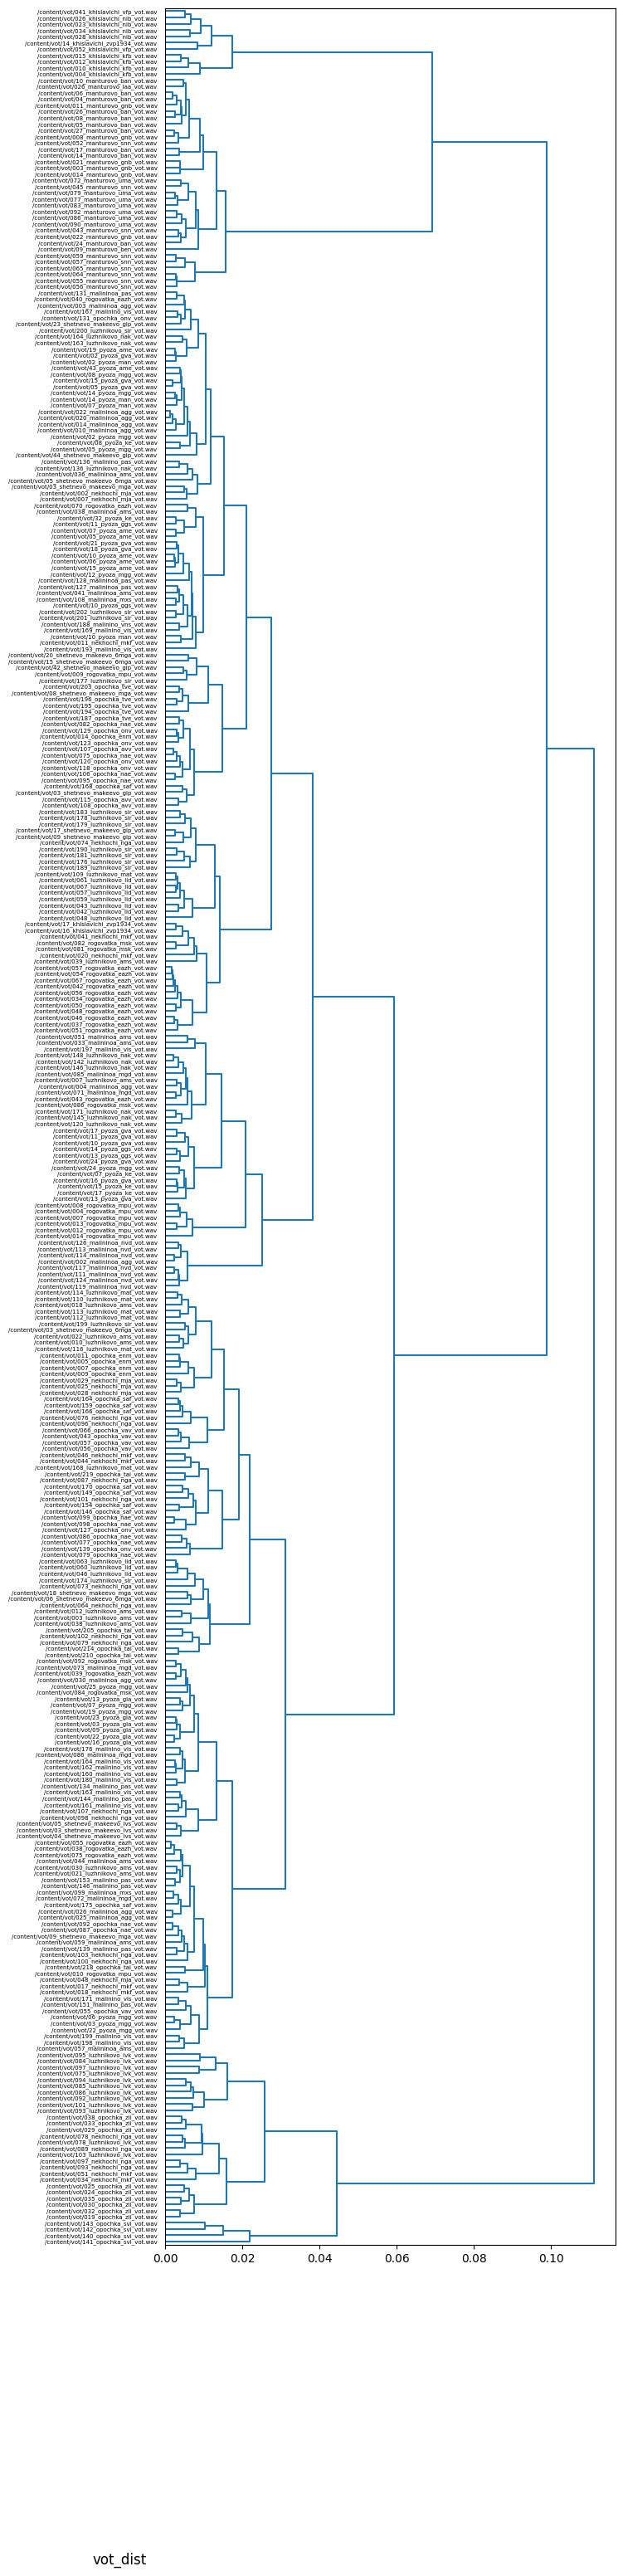

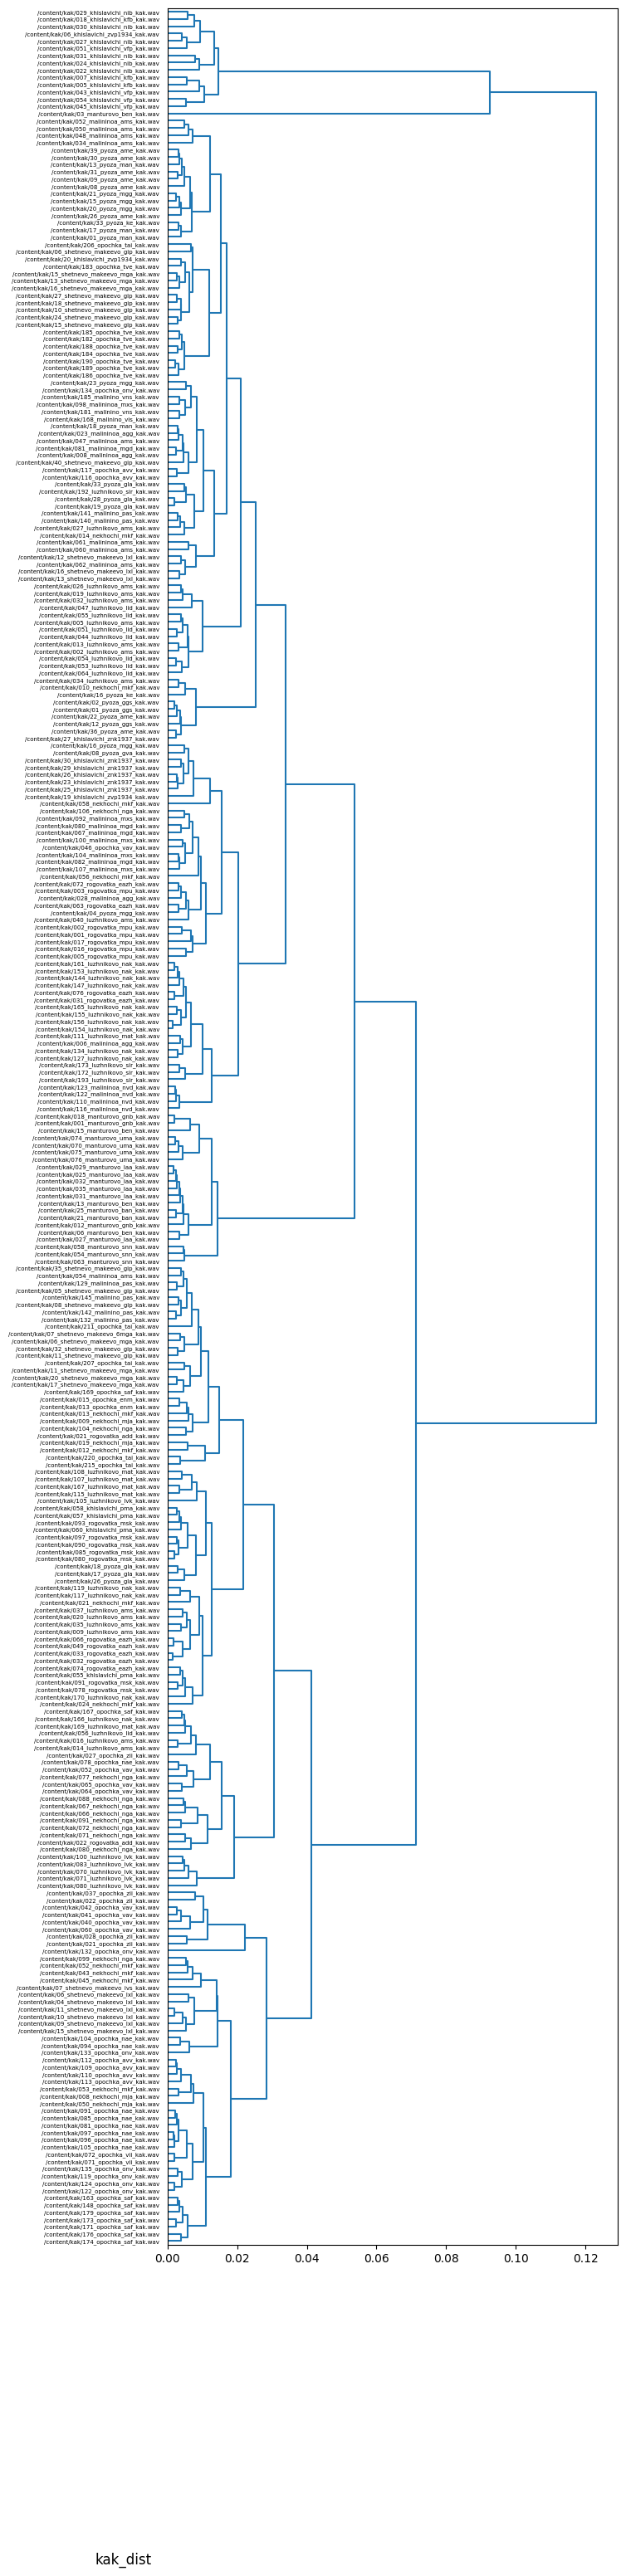

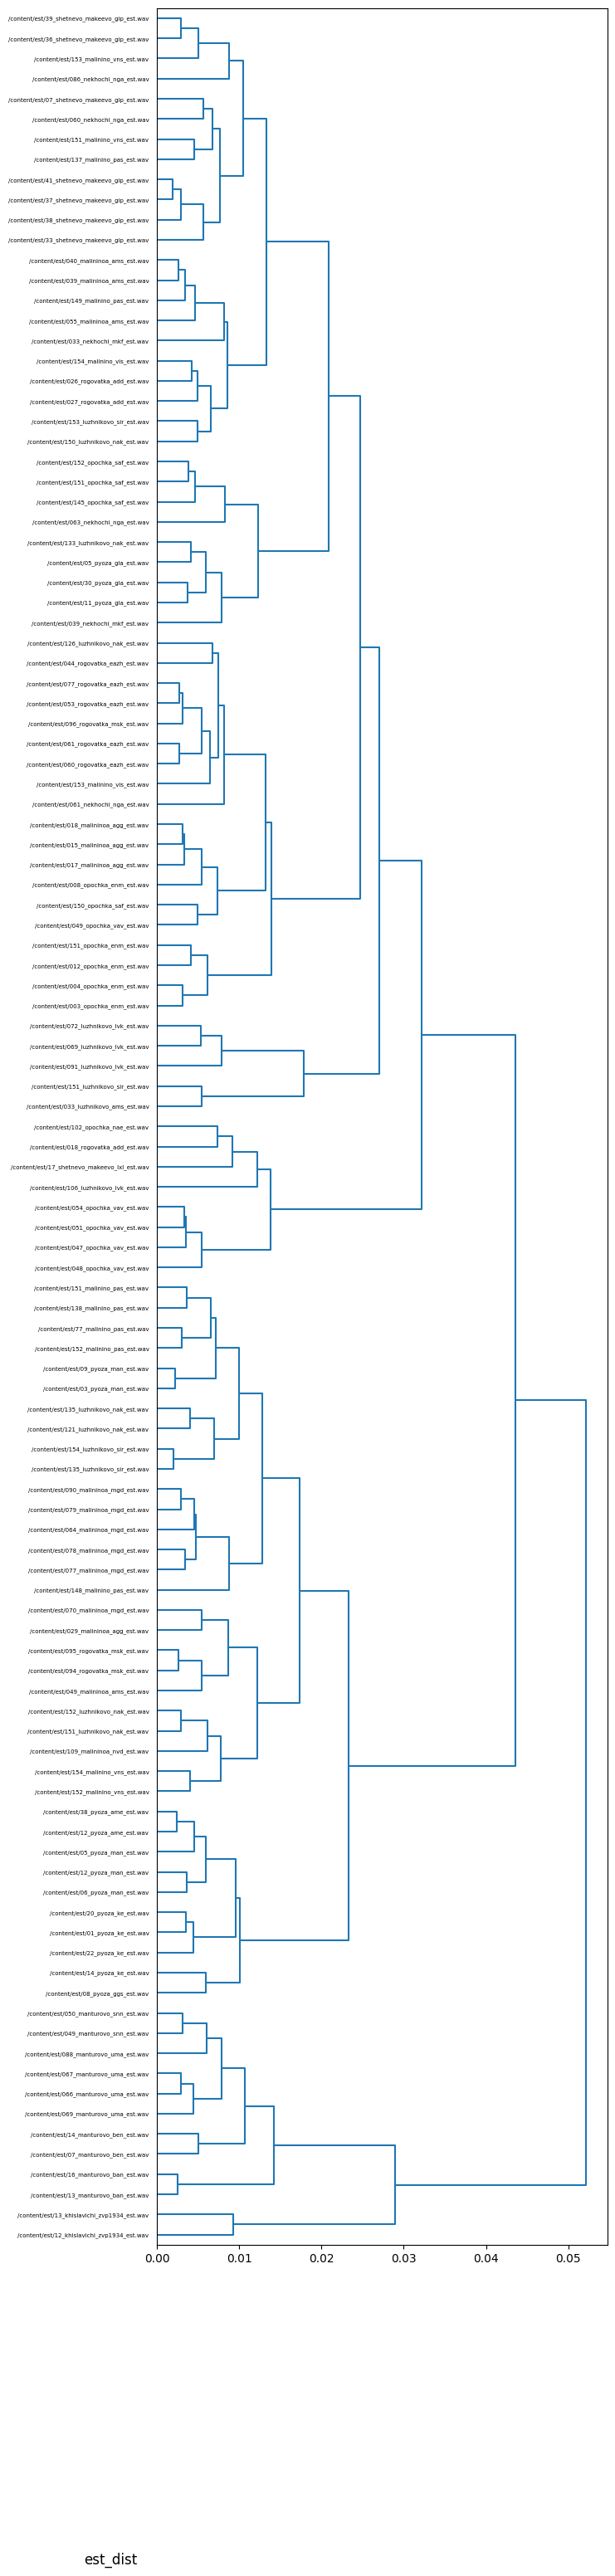

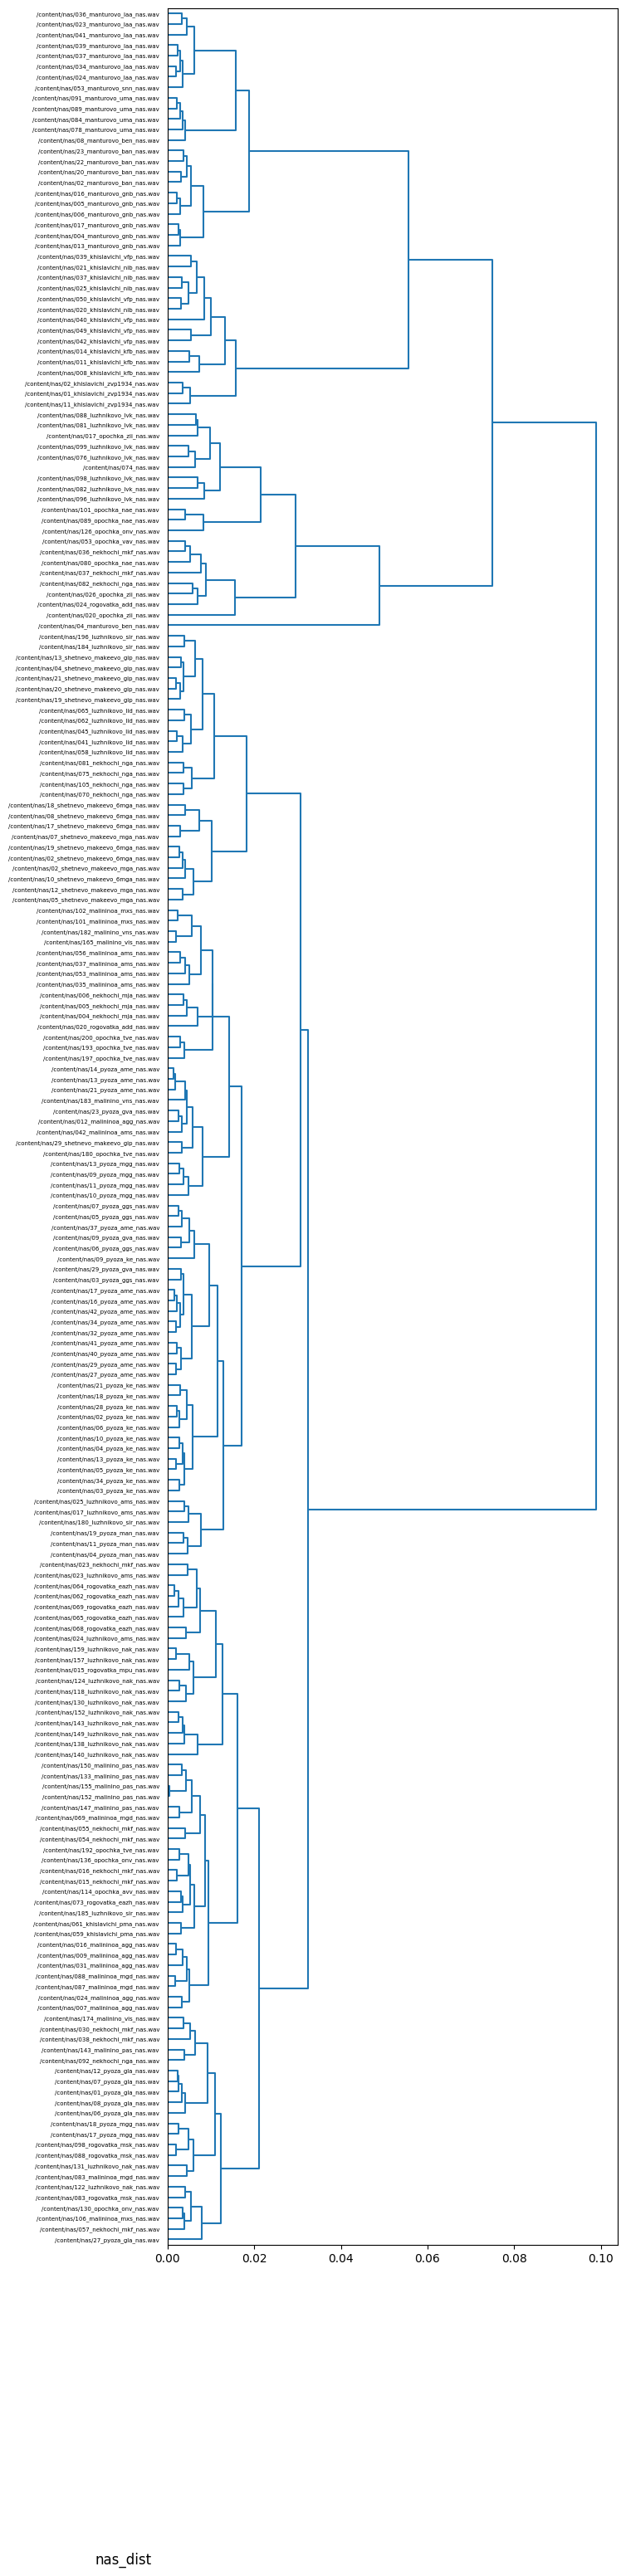

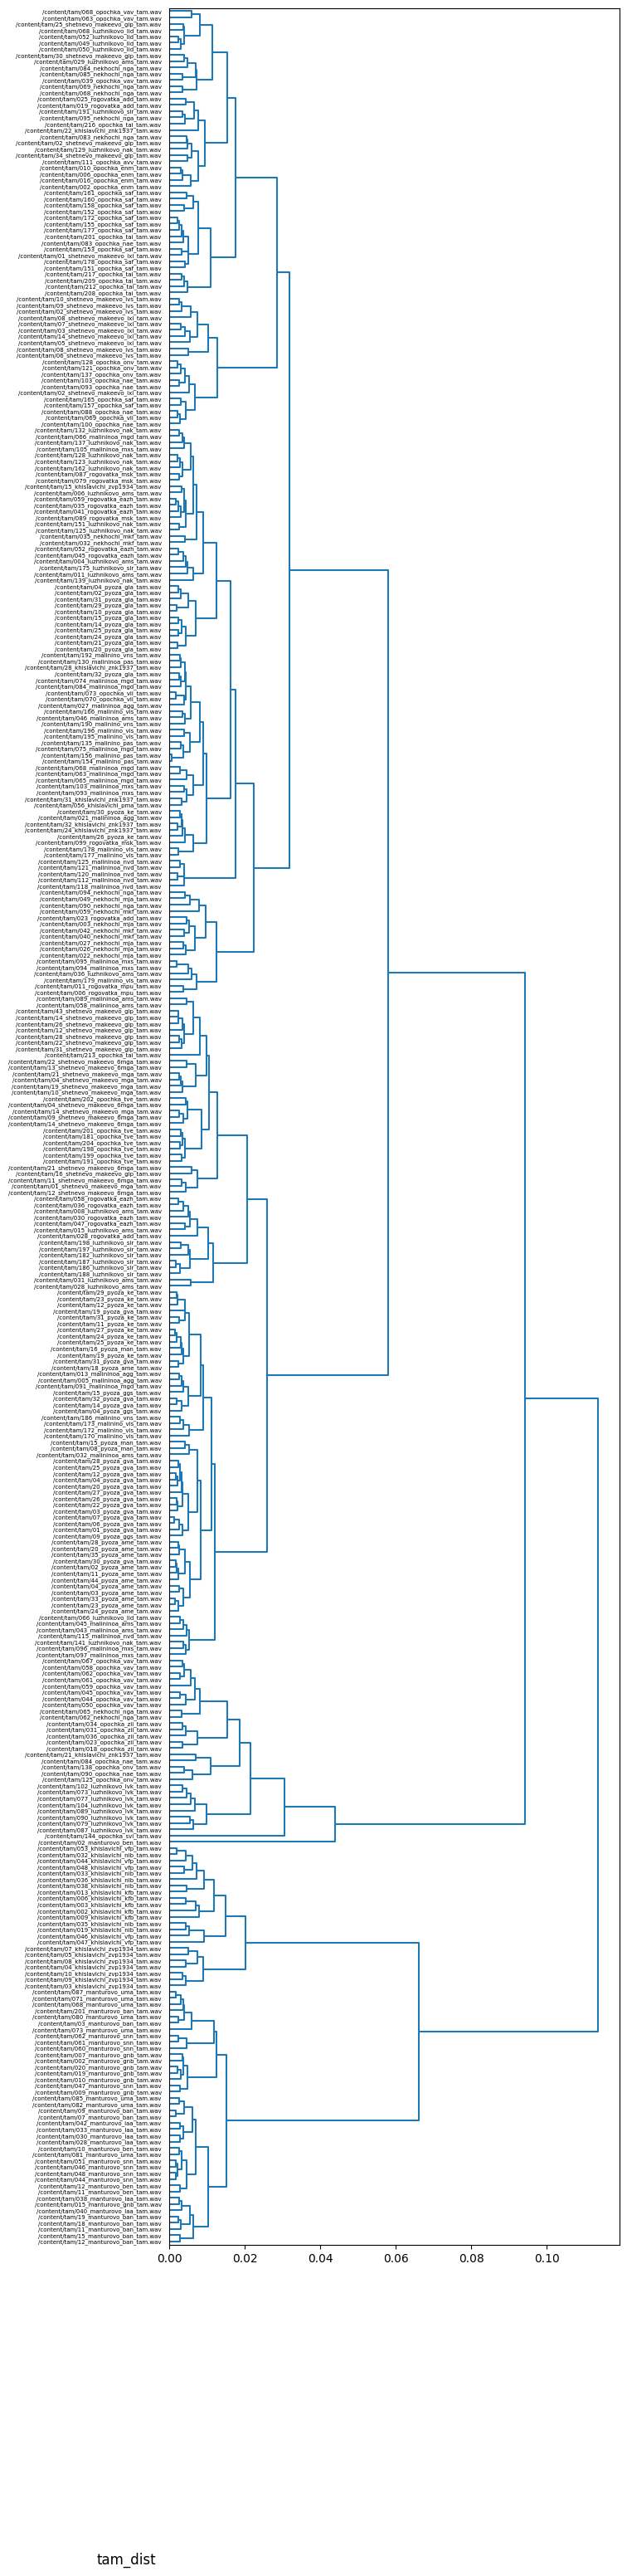

In [ ]:
dataframes = [vot_dist, kak_dist, est_dist, nas_dist, tam_dist]  # List of DataFrames
tags = ['vot_dist', 'kak_dist', 'est_dist', 'nas_dist', 'tam_dist']  # List of tags

clustering_alpha_multiple(dataframes, tags)